In [1]:
from ase.io import read, write
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS, FIRE, MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units, Atoms
from ase.calculators.lj import LennardJones
from castle import utils, LinearPotential, LPEnsemble, LPLocalEnsemble, print_score, AceRepresentation, ASEMLCalculator, ExpandedPotential
import dadapy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl


rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1, 'W':5.0, "P": 5.0}

%load_ext autoreload
%autoreload 2

In [2]:
# import os
# root = "/home/claudio/postdoc/data/P/P_test"
# test_traj = []
# for path, subdirs, files in os.walk(root):
#     for name in files:
#         if name.endswith(".xyz"):
#             traj_ = read(path + "/" + name, index = ':')
#             try:
#                 _ = [a.get_array("forces") for a in traj_]
#                 test_traj.extend(traj_)
#             except KeyError:
#                 print(f"{name} does not contain forces")
                
# write("/home/claudio/postdoc/data/P/test.xyz", test_traj)

bulk.xyz does not contain forces
bulk_all.xyz does not contain forces
Hittorf_Angew2020.vasp_STEPS.xyz does not contain forces
Hittorf_ActaB1969.vasp_STEPS.xyz does not contain forces
bulk.xyz does not contain forces
bulk.xyz does not contain forces
bulk.xyz does not contain forces
bulk.xyz does not contain forces


/home/claudio/.local/lib/python3.8/site-packages/ase/io/extxyz.py:997: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


In [2]:
species = 'P'
N = 4
maxdeg = 12
rcut = rcuts[species]
force_name = 'forces'
energy_name = 'energy'
e_noise = 1e-8
f_noise = 1e-8
root = f"/home/claudio/postdoc/data/{species}/"

# tr_features, val_features = utils.extract_features(root, "train.xyz", "test.xyz", 
#                                                    N=N, maxdeg=maxdeg, rcut=rcut, force_name=force_name,
#                                                    energy_name=energy_name, species=species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train.xyz", "test.xyz", 
    f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",  f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
    force_name = force_name, energy_name =energy_name)

In [3]:
filter = e_val/nat_val < np.quantile(e_val/nat_val, 0.99)
f_val_ = []
start = 0
for i, s in enumerate(val_features.get_nb_atoms_per_frame()):
    if filter[i]:
        f_val_.extend(f_val[start:start+s])
    start += s
f_val_ = np.array(f_val_)
val_features_ = val_features.get_subset(np.arange(len(e_val))[filter])
e_val_ = e_val[filter]
nat_val_ = nat_val[filter]

CPU times: user 113 ms, sys: 260 ms, total: 373 ms
Wall time: 47.4 ms
MAE=0.106 RMSE=0.328 SUP=4.764 R2=0.801
MAE=0.229 RMSE=0.378 SUP=45.084 R2=0.861


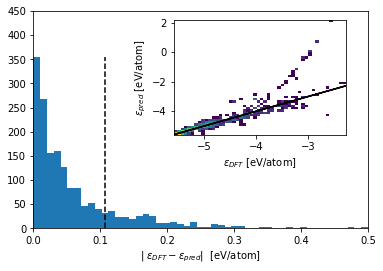

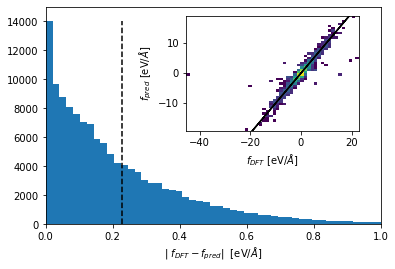

In [7]:
representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
model_lin = LinearPotential(representation)
model_lin.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False)

# evaluate its performances
%time predictions = model_lin.predict_from_features(val_features_, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val_, e_val_/nat_val_)
print_score(fp.flatten(), f_val_.flatten())


fig, ax = plt.subplots()
left, bottom, width, height = [.45, 0.45, 0.4, 0.4]
ax_new = fig.add_axes([left, bottom, width, height])
hist = ax.hist(abs(e_val_/nat_val_- ep/nat_val_), bins = np.linspace(0, .5, 50))
ax.vlines(np.mean(abs(e_val_/nat_val_- ep/nat_val_)), 0, max(hist[0]), color= 'k', linestyle = '--', lw = 1.5)
ax_new.hist2d(e_val_/nat_val_, ep/nat_val_, cmin=1e-12, bins = 50, norm=mpl.colors.LogNorm())
ax_new.plot(e_val_/nat_val_, e_val_/nat_val_, 'k-')
ax_new.set_xlabel("$\epsilon_{DFT}$ [eV/atom]")
ax_new.set_ylabel("$\epsilon_{pred}$ [eV/atom]")
ax.set_xlim(0, .5)
ax.set_xlabel("| $\epsilon_{DFT}- \epsilon_{pred}|$  [eV/atom]")
ax.set_ylim(0, 450)
plt.savefig(f"../../plots/divide/validation_energy_error_{species}_linear_N_{N}_maxdeg_{maxdeg}.pdf")
plt.show()

fig, ax = plt.subplots()
left, bottom, width, height = [.45, 0.45, 0.4, 0.4]
ax_new = fig.add_axes([left, bottom, width, height])
hist = ax.hist(abs(f_val_.ravel() - fp.ravel()), bins = np.linspace(0, 1, 50))
ax.vlines(np.mean(abs(f_val_.ravel() - fp.ravel())), 0, max(hist[0]), color= 'k', linestyle = '--', lw = 1.5)
ax_new.hist2d(f_val_.ravel(), fp.ravel(), cmin=1e-12, bins = 50, norm=mpl.colors.LogNorm())
ax_new.plot(f_val_.ravel(), f_val_.ravel(), 'k-')
ax_new.set_xlabel("$f_{DFT}$ [eV/$\AA$]")
ax_new.set_ylabel("$f_{pred}$ [eV/$\AA$]")
ax.set_xlim(0, 1)
ax.set_ylim(0, 15000)
ax.set_xlabel("| $f_{DFT}- f_{pred}|$  [eV/$\AA$]")
plt.savefig(f"../../plots/divide/validation_force_error_{species}_linear_N_{N}_maxdeg_{maxdeg}.pdf")
plt.show()

CPU times: user 218 ms, sys: 368 ms, total: 586 ms
Wall time: 102 ms
MAE=0.058 RMSE=0.102 SUP=1.422 R2=0.956
MAE=0.230 RMSE=0.338 SUP=8.293 R2=0.920


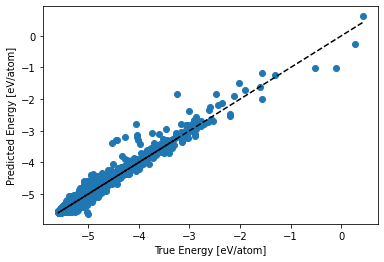

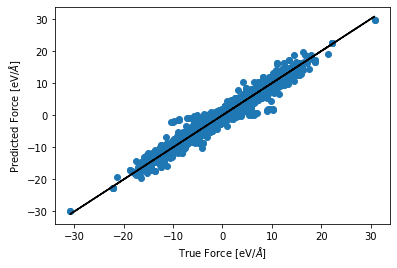

In [43]:
%time predictions = model_lin.predict_from_features(tr_features, forces=True)
et = predictions['energy']
ft = predictions['forces']
print_score(et/nat_tr, e_t/nat_tr)
print_score(ft.flatten(), f_t.flatten())

plt.scatter(e_t/nat_tr, et/nat_tr)
plt.plot(e_t/nat_tr, e_t/nat_tr, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_t, ft)
plt.plot(f_t, f_t, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 76.4 ms, sys: 158 ms, total: 234 ms
Wall time: 29.8 ms
MAE=0.075 RMSE=0.180 SUP=2.393 R2=0.921
MAE=0.220 RMSE=0.325 SUP=5.235 R2=0.901


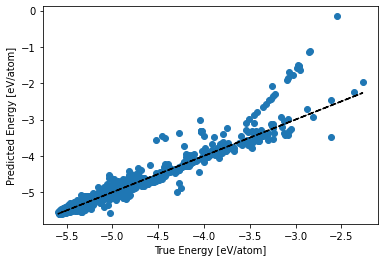

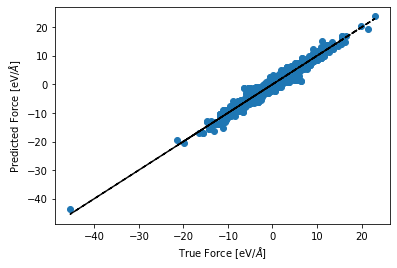

In [56]:
model_lin.update_from_features(val_features_, e_val_, f_val_)# evaluate its performances
%time predictions = model_lin.predict_from_features(val_features_, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val_, e_val_/nat_val_)
print_score(fp.flatten(), f_val_.flatten())

plt.scatter(e_val_/nat_val_, ep/nat_val_)
plt.plot(e_val_/nat_val_, e_val_/nat_val_, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val_, fp)
plt.plot(f_val_, f_val_, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

# Ensemble Model

Clustering data
Using 6 clusters
CPU times: user 1.41 s, sys: 626 ms, total: 2.03 s
Wall time: 1.23 s
MAE=0.055 RMSE=0.114 SUP=1.014 R2=0.960
MAE=0.220 RMSE=0.336 SUP=12.100 R2=0.896


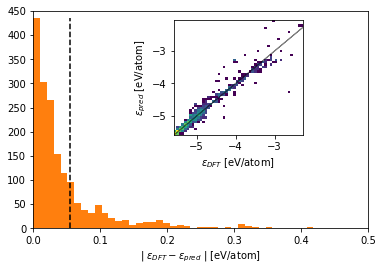

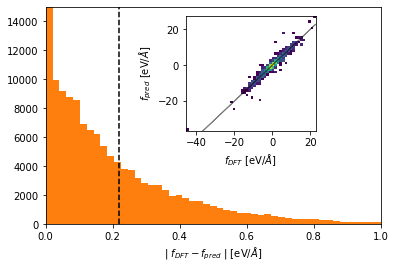

In [29]:
# train the model
representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
model_ens = LPEnsemble(representation, n_clusters=6, clustering_type='kmeans', baseline_percentile=0)
model_ens.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False)
# evaluate its performances
%time predictions = model_ens.predict_from_features(val_features_, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val_, e_val_/nat_val_)
print_score(fp.flatten(), f_val_.flatten())




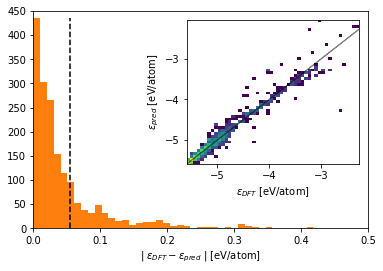

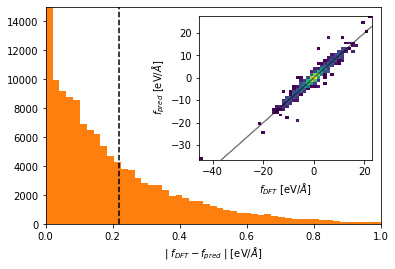

In [33]:
fig, ax = plt.subplots()
left, bottom, width, height = [.48, 0.35, 0.4, 0.5]
ax_new = fig.add_axes([left, bottom, width, height])
hist = ax.hist(abs(e_val_/nat_val_- ep/nat_val_), bins = np.linspace(0, .5, 50), color = 'tab:orange')
ax.vlines(np.mean(abs(e_val_/nat_val_- ep/nat_val_)), 0, max(hist[0]), color= 'k', linestyle = '--', lw = 1.5)
ax_new.hist2d(e_val_/nat_val_, ep/nat_val_, cmin=1e-12, bins = 50, norm=mpl.colors.LogNorm())
ax_new.plot(e_val_/nat_val_, e_val_/nat_val_, 'k-', lw=1, alpha=.5)
ax_new.set_xlabel("$\epsilon_{DFT}$ [eV/atom]")
ax_new.set_ylabel("$\epsilon_{pred}$ [eV/atom]")
ax.set_xlim(0, .5)
ax.set_ylim(0, 450)
ax.set_xlabel("| $\epsilon_{DFT}- \epsilon_{pred}$ | [eV/atom]")
plt.savefig(f"../../plots/divide/validation_energy_error_{species}_ensemble_N_{N}_maxdeg_{maxdeg}.pdf")
plt.show()

fig, ax = plt.subplots()
left, bottom, width, height = [.48, 0.35, 0.4, 0.5]
ax_new = fig.add_axes([left, bottom, width, height])
hist = ax.hist(abs(f_val_.ravel() - fp.ravel()), bins = np.linspace(0, 1, 50), color = 'tab:orange')
ax.vlines(np.mean(abs(f_val_.ravel() - fp.ravel())), 0, max(hist[0]), color= 'k', linestyle = '--', lw = 1.5)
ax_new.plot(f_val_.ravel(), f_val_.ravel(), 'k-', lw=1, alpha=.5)
ax_new.hist2d(f_val_.ravel(), fp.ravel(), cmin=1e-12, bins = 50, norm=mpl.colors.LogNorm())
ax_new.set_xlabel("$f_{DFT}$ [eV/$\AA$]")
ax_new.set_ylabel("$f_{pred}$ [eV/$\AA$]")
ax.set_xlim(0, 1)
ax.set_ylim(0, 15000)
ax.set_xlabel("| $f_{DFT}- f_{pred}$ | [eV/$\AA$]")
plt.savefig(f"../../plots/divide/validation_force_error_{species}_ensemble_N_{N}_maxdeg_{maxdeg}.pdf")
plt.show()

CPU times: user 4.13 s, sys: 0 ns, total: 4.13 s
Wall time: 4.13 s
MAE=0.047 RMSE=0.083 SUP=0.987 R2=0.970
MAE=0.211 RMSE=0.316 SUP=7.429 R2=0.930


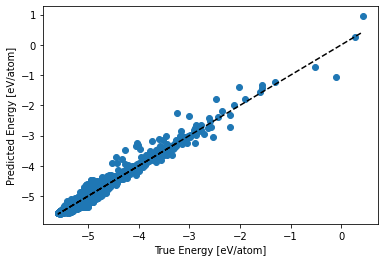

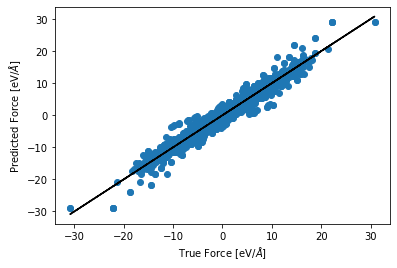

In [54]:
%time predictions = model_ens.predict_from_features(tr_features, forces=True)
et = predictions['energy']
ft = predictions['forces']
print_score(et/nat_tr, e_t/nat_tr)
print_score(ft.flatten(), f_t.flatten())

plt.scatter(e_t/nat_tr, et/nat_tr)
plt.plot(e_t/nat_tr, e_t/nat_tr, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_t, ft)
plt.plot(f_t, f_t, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 1.67 s, sys: 655 ms, total: 2.33 s
Wall time: 1.52 s
MAE=0.054 RMSE=0.112 SUP=0.714 R2=0.957
MAE=0.201 RMSE=0.296 SUP=5.301 R2=0.917


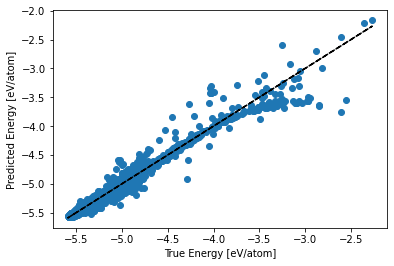

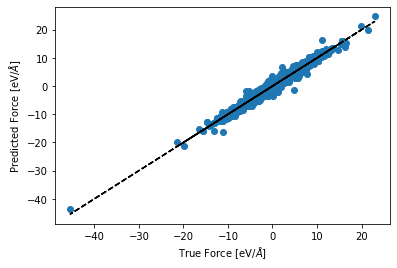

In [55]:
model_ens.update_from_features(val_features_, e_val_, f_val_)# evaluate its performances
%time predictions = model_ens.predict_from_features(val_features_, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val_, e_val_/nat_val_)
print_score(fp.flatten(), f_val_.flatten())

plt.scatter(e_val_/nat_val_, ep/nat_val_)
plt.plot(e_val_/nat_val_, e_val_/nat_val_, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val_, fp)
plt.plot(f_val_, f_val_, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

In [107]:
X = np.concatenate([tr_features.X, tr_features.X_std], axis =1)
Y = np.concatenate([val_features_.X, val_features_.X_std], axis =1)

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_ = (X - mean[None, :]) / std[None, :]
Y_ = (Y - mean[None, :]) / std[None, :]
data = dadapy.Data(X_)
dens_tr , dens_tr_err = data.compute_density_PAk()
data.compute_clustering_ADP(10, halo=False)
n_clusters = data.N_clusters
labels = data.cluster_assignment
dens_val, dens_val_err = data.return_interpolated_density_PAk(Y_)

Clustering data
Using 15 clusters
Using 15 clusters


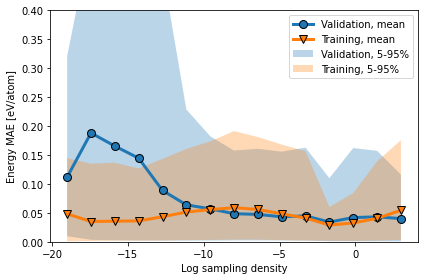

In [93]:
low = int(np.quantile(np.concatenate([dens_val, dens_tr]), .01))
high = int(np.quantile(np.concatenate([dens_val, dens_tr]), .99))
ncenter = 15
model = 'ensemble'

representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
if model == 'linear':
    model_ = LinearPotential(representation)
elif model == 'ensemble':
    model_ = LPEnsemble(representation, n_clusters='auto', clustering_type='kmeans', baseline_percentile=0)
model_.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False)
predictions = model_.predict_from_features(val_features_, forces=True)
ep = predictions['energy']
fp = predictions['forces']

denss = dens_val
errss = abs((e_val_/nat_val_ - ep/nat_val_))

plt.figure(figsize = (6, 4))
centers = np.linspace(low, high, ncenter)
binwidth = (high - low) / (len(centers))*2
binned_error = np.empty(len(centers))*np.nan
binned_error_std = np.empty(len(centers))*np.nan
binned_error_95 = np.empty(len(centers))*np.nan
binned_error_5 = np.empty(len(centers))*np.nan

for cc, c in enumerate(centers):
    ind = (denss < c + binwidth) & (denss > c - binwidth)
    if sum(ind)/len(denss) > 0.02:
        binned_error[cc] = np.mean(errss[ind])
        binned_error_std[cc] = np.std(errss[ind])
        binned_error_95[cc] = np.quantile(errss[ind], .95)
        binned_error_5[cc] = np.quantile(errss[ind], .05)

plt.plot(centers, binned_error, lw = 3,
         markersize = 8,mec = 'k', marker = 'o', label = 'Validation, mean')
# plt.plot(centers, binned_error_95, lw = 3,
#          markersize = 8,mec = 'k', marker = 'o', linestyle = ':', color = 'tab:blue', label = 'Validation, 95%')
plt.fill_between(centers, binned_error_95, binned_error_5, alpha = 0.3, label = 'Validation, 5-95%')

denss = dens_tr
errss = abs((e_t/nat_tr - et/nat_tr))
for cc, c in enumerate(centers):
    ind = (denss < c + binwidth) & (denss > c - binwidth)
    if sum(ind)/len(denss) > 0.02:
        binned_error[cc] = np.mean(errss[ind])
        binned_error_std[cc] = np.std(errss[ind])
        binned_error_95[cc] = np.quantile(errss[ind], .95)
        binned_error_5[cc] = np.quantile(errss[ind], .05)

plt.plot(centers, binned_error, lw = 3,
         markersize = 8,mec = 'k', marker = 'v', label = 'Training, mean')
# plt.plot(centers, binned_error_95, lw = 3,
#          markersize = 8,mec = 'k', marker = 'v', linestyle = ':', color = 'tab:orange', label = 'Training, 95%')
plt.fill_between(centers, binned_error_95, binned_error_5, alpha = 0.3, label = 'Training, 5-95%')
plt.xlabel("Log sampling density")
plt.ylabel("Energy MAE [eV/atom]")

plt.yscale(scale)
plt.legend()
plt.ylim(0, .4)
plt.tight_layout()
plt.savefig(f"../../plots/divide/energy_error_vs_sanpling_density_{species}_{model}.pdf")

In [18]:
tr_local_features, val_local_features = utils.extract_local_features(root, "train.xyz", "test.xyz", 
                                                   N=N, maxdeg=maxdeg, rcut=rcut, force_name=force_name,
                                                   energy_name=energy_name, species=species, compute_derivative=False)

Computing Local Features[############################################################] 4798/4798
Computing Local Features[############################################################] 1793/1793


In [23]:
X = []
for i in tr_local_features.X:
    X.extend(i[:, :-1])
X = np.array(X)

Y = []
for i, x in enumerate(val_local_features.X):
    if filter[i]:
        Y.extend(x[:, :-1])
Y = np.array(Y)

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

X_ = (X - mean[None, :])
Y_ = (Y - mean[None, :]) 

np.save(root + f"tr_local_features_N{N}_maxdeg{maxdeg}.npy", X_)
np.save(root + f"val_local_features_N{N}_maxdeg{maxdeg}.npy", Y_)

In [28]:

data = dadapy.Data(X_)
dens_tr , dens_tr_err = data.compute_density_PAk()
data.compute_clustering_ADP(10, halo=False)
n_clusters = data.N_clusters
labels = data.cluster_assignment
dens_val, dens_val_err = data.return_interpolated_density_PAk(Y_)

/home/claudio/.local/lib/python3.8/site-packages/dadapy/_utils/utils.py:150: UserWarning: there may be data with zero distance from each other; this may compromise the correct behavior of some routines
  warnings.warn(
/home/claudio/.local/lib/python3.8/site-packages/dadapy/id_estimation.py:167: RuntimeWarning: divide by zero encountered in true_divide
  mus[j] = np.log(distances[:, 2] / distances[:, 1])
/home/claudio/.local/lib/python3.8/site-packages/dadapy/_utils/density_estimation.py:97: RuntimeWarning: divide by zero encountered in log
  exponent = intrinsic_dim * np.log(r1) + np.log(
/home/claudio/.local/lib/python3.8/site-packages/dadapy/_utils/density_estimation.py:98: RuntimeWarning: invalid value encountered in double_scalars
  1 - (r / r1) ** intrinsic_dim


MemoryError: Unable to allocate 148. GiB for an array with shape (140910, 140910) and data type float64

In [ ]:
plt.show()